# Lab session 5: Deep Learning for Graphs (1/2)

## Learning objective 

In this lab, you will learn about neural networks that operate on graphs. These models can be employed for addressing various tasks such as node classification, graph classification and link prediction. The lab is divided into two parts. 

In the first part, you will implement a model that generates node embeddings in an unsupervised manner. These embeddings can then be fed to conventional machine learning algorithms for solving any downstream task. 

In the second part, you will implement a graph neural network and you will evaluate it in a node classification task. We will use Python,
and the following three libraries: (1) Gensim (https://radimrehurek.com/gensim/), (2) PyTorch (https://pytorch.org/), and (3) NetworkX (http://networkx.github.io/).

## Imports

In [2]:
!pip install deepwalk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os
import numpy as np
import networkx as nx
from random import randint
from gensim.models import Word2Vec


import deepwalk
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import accuracy_score

import scipy.sparse as sp
from sklearn.preprocessing import LabelEncoder

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/MVA/ALTEGRAD/labs/lab5/code')

Mounted at /content/drive/


# Part 1

## task 1

In [2]:
############## Task 1
import random
# Simulates a random walk of length "walk_length" starting from node "node"
def random_walk(G, node, walk_length):

    ##################
    node_=node
    walk=[node_]
    for _ in range(walk_length):
      neighbors=list(G.neighbors(node_))
      node_=random.choice(neighbors)
      walk.append(node_)
    
    random.shuffle(walk)
    ##################
    walk = [str(node) for node in walk]
    return walk

## task 2

In [3]:
############## Task 2
# Runs "num_walks" random walks from each node
def generate_walks(G, num_walks, walk_length):
    walks = []
    nodes=list(G.nodes)
    ##################
    for node in nodes:
      for _ in range(num_walks):
        walks.append(random_walk(G, node, walk_length))
    ##################
    random.shuffle(walks)
    #permuted_walks=walks
    #return permuted_walks.tolist()
    return walks


# Simulates walks and uses the Skipgram model to learn node representations
def deepwalk(G, num_walks, walk_length, n_dim):
    print("Generating walks")
    walks = generate_walks(G, num_walks, walk_length)

    print("Training word2vec")
    model = Word2Vec(size=n_dim, window=8, min_count=0, sg=1, workers=8, hs=1)
    model.build_vocab(walks)
    model.train(walks, total_examples=model.corpus_count, epochs=5)

    return model

## task 3

In [4]:
# Loads the web graph
G = nx.read_weighted_edgelist('./data/web_sample.edgelist', delimiter=' ', create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 33226
Number of edges: 354529


In [5]:
############## Task 3
# Extracts a set of random walks from the web graph and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20

##################
model=deepwalk(G, n_walks, walk_length, n_dim)

Generating walks
Training word2vec


## task 4 

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


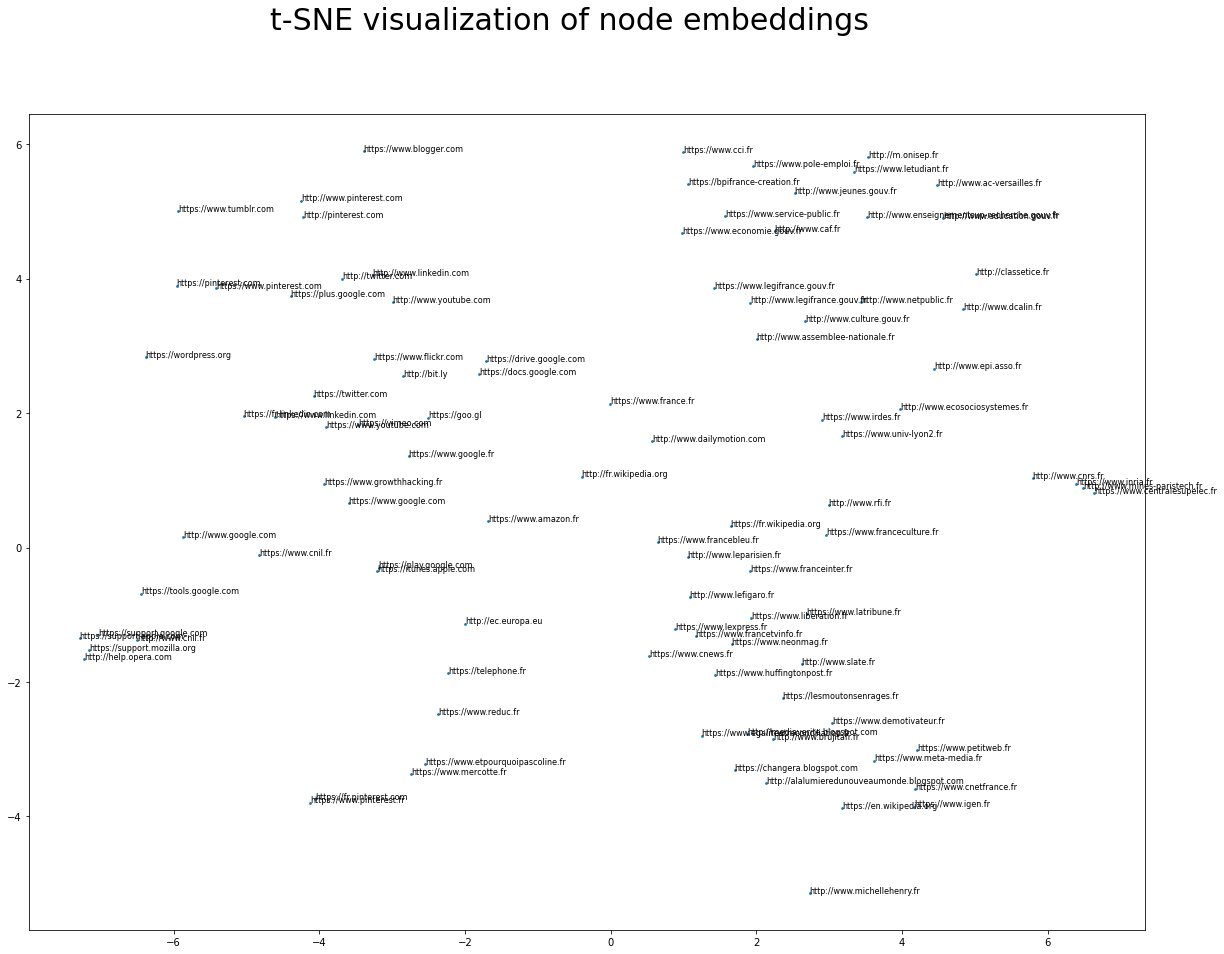

In [ ]:
############## Task 4
# Visualizes the representations of the 100 nodes that appear most frequently in the generated walks
def visualize(model, n, dim):

    nodes = model.wv.index2entity[:n]
    DeepWalk_embeddings = np.empty(shape=(n, dim))
    
    ##################
    for i in range(n):
      node=nodes[i]
      emb=model.wv[node]
      DeepWalk_embeddings[i]=emb
    ##################


    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2)

    vecs_pca = my_pca.fit_transform(DeepWalk_embeddings)
    vecs_tsne = my_tsne.fit_transform(vecs_pca)

    fig, ax = plt.subplots()
    ax.scatter(vecs_tsne[:,0], vecs_tsne[:,1],s=3)
    for x, y, node in zip(vecs_tsne[:,0] , vecs_tsne[:,1], nodes):     
        ax.annotate(node, xy=(x, y), size=8)
    fig.suptitle('t-SNE visualization of node embeddings',fontsize=30)
    fig.set_size_inches(20,15)
    plt.savefig('embeddings.pdf')  
    plt.show()


visualize(model, 100, n_dim)

## task 5

In [6]:
# Loads the karate network
G = nx.read_weighted_edgelist('./data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('./data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)

Number of nodes: 34
Number of edges: 78


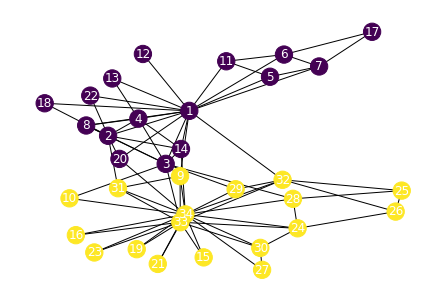

In [ ]:

############## Task 5
# Visualizes the karate network
##################
nx.draw(G, cmap=plt.get_cmap('viridis'), node_color=y, with_labels=True, font_color='white')
##################

## task 6

In [ ]:
############## Task 6
# Extracts a set of random walks from the karate network and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20
model = deepwalk(G, n_walks, walk_length, n_dim) # your code here

embeddings = np.zeros((n, n_dim))
for i, node in enumerate(G.nodes()):
    embeddings[i,:] = model.wv[str(node)]

idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

X_train = embeddings[idx_train,:]
X_test = embeddings[idx_test,:]

y_train = y[idx_train]
y_test = y[idx_test]


Generating walks
Training word2vec


## task 7 

In [ ]:
############## Task 7
# Trains a logistic regression classifier and use it to make predictions

##################
#modeling
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
#predictions
logistic_regression_pred = logistic_regression.predict(X_test)
##################
print(accuracy_score(y_test, logistic_regression_pred))

1.0


## task 8 

In [ ]:
############## Task 8
# Generates spectral embeddings

##################
# your code here #
##################

# Part 2

In the second part of the lab, we will focus on the problem of supervised node classification. We will
implement a graph neural network (GNN) for learning node representations and performing node
classification. GNNs follow a recursive neighborhood aggregation (or message passing) scheme,
where each node aggregates feature vectors of its neighbors to compute its new feature vector. After
k iterations of aggregation, a node is represented by its transformed feature vector, which captures the
structural information within the node’s k-hop neighborhood.

## task 9

In [7]:
from scipy import sparse
def normalize_adjacency(A):
    ############## Task 9

    ##################
    
    A_bar= A +np.identity(A.shape[0])
    D=np.zeros(A.shape)

    for i in range(A.shape[0]):
      D[i,i]=np.sqrt(1/np.sum(A_bar[i,:]))
   
  
    A_normalized=(D @ A_bar ) 
    A_normalized=A_normalized@ D
    ##################
    return sparse.csr_matrix(A_normalized)

In [9]:
#question 4
from scipy.linalg import fractional_matrix_power

#Get the Adjacency Matrix (A) and Node Features Matrix (X) as numpy array
A = nx.adjacency_matrix(G)
X = np.ones((34,1))
#Symmetrically-normalization
A_norm = normalize_adjacency(A)
print('=========')
print('Graph K4')
print('=========')
print('\nAdjacency Matrix (A):\n', A.toarray())
print('\nNormalized adjacency Matrix (A^):\n', A_norm.toarray())
print('\nNode Attributes Matrix (X):\n', X)

W0 = np.array([[-0.8, 0.5]])
print('\nFirst layer Weight Matrix (W0):\n', W0)

Z0 = np.maximum(0, A_norm@X@W0)
print('\nFirst layer embeddings (Z0):\n', Z0)

W1 = np.array([[0.1, 0.3, -0.05], [-0.4, 0.6, 0.5]])
print('\nSecond layer Weight Matrix (W1):\n', W1)

Z1 = np.maximum(0, A_norm@Z0@W1)
print('\nSecond layer embeddings (Z1):\n', Z1)

Graph K4

Adjacency Matrix (A):
 [[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 1 1 0]]

Normalized adjacency Matrix (A^):
 [[0.05882353 0.0766965  0.07312724 ... 0.         0.         0.        ]
 [0.0766965  0.1        0.09534626 ... 0.         0.         0.        ]
 [0.07312724 0.09534626 0.09090909 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.33333333 0.         0.13608276]
 [0.         0.         0.         ... 0.         0.33333333 0.13608276]
 [0.         0.         0.         ... 0.13608276 0.13608276 0.05555556]]

Node Attributes Matrix (X):
 [[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]

First layer Weight Matrix (W0):
 [[-0.8  0.5]]

First layer embeddings (Z0):
 [[0.         0.93539911]
 [0.         0.66338502]
 [0

In [ ]:
def load_cora():
    idx_features_labels = np.genfromtxt("./data/cora.content", dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    features = features.todense()
    features /= features.sum(1).reshape(-1, 1)
    
    class_labels = idx_features_labels[:, -1]
    le = LabelEncoder()
    class_labels = le.fit_transform(class_labels)

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("./data/cora.cites", dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(class_labels.size, class_labels.size), dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    print('Dataset has {} nodes, {} edges, {} features.'.format(adj.shape[0], edges.shape[0], features.shape[1]))

    return features, adj, class_labels


def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

## task 10

In [ ]:
class GNN(nn.Module):
    """Simple GNN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class, dropout):
        super(GNN, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj):
        ############## Tasks 10 and 13
        
        ##################
        # your code here #
        Z=torch.mm(adj, x_in)
        Z=self.fc1(Z)
        Z=self.relu(Z)
        Z=self.dropout(Z)
        Z=torch.mm(adj, Z)
        Z=self.fc2(Z)
        Z=self.relu(Z)
        Z=self.fc3(Z)

        ##################


        return F.log_softmax(Z, dim=1)

## task 11

In [ ]:
# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 8
n_hidden_2 = 16
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
G = nx.read_weighted_edgelist('./data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print('number of nodes: ',G.number_of_nodes())
print('number of edges',G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('./data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix

############## Task 12
# Set the feature of all nodes to the same value
features = np.eye(n) # Generates node features


# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)



# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
test()

number of nodes:  34
number of edges 78
Epoch: 001 loss_train: 0.6867 acc_train: 0.5556 time: 0.0915s
Epoch: 002 loss_train: 0.6839 acc_train: 0.5556 time: 0.0030s
Epoch: 003 loss_train: 0.6814 acc_train: 0.5556 time: 0.0034s
Epoch: 004 loss_train: 0.6796 acc_train: 0.5556 time: 0.0013s
Epoch: 005 loss_train: 0.6754 acc_train: 0.5556 time: 0.0032s
Epoch: 006 loss_train: 0.6736 acc_train: 0.5556 time: 0.0016s
Epoch: 007 loss_train: 0.6642 acc_train: 0.5556 time: 0.0031s
Epoch: 008 loss_train: 0.6562 acc_train: 0.5556 time: 0.0031s
Epoch: 009 loss_train: 0.6449 acc_train: 0.5556 time: 0.0034s
Epoch: 010 loss_train: 0.6344 acc_train: 0.5556 time: 0.0013s
Epoch: 011 loss_train: 0.6268 acc_train: 0.5926 time: 0.0021s
Epoch: 012 loss_train: 0.6172 acc_train: 0.6296 time: 0.0023s
Epoch: 013 loss_train: 0.5874 acc_train: 0.8148 time: 0.0016s
Epoch: 014 loss_train: 0.5712 acc_train: 0.8889 time: 0.0012s
Epoch: 015 loss_train: 0.5601 acc_train: 0.8889 time: 0.0022s
Epoch: 016 loss_train: 0.5313 

## task 12

In [ ]:
# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 8
n_hidden_2 = 16
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
G = nx.read_weighted_edgelist('./data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print('number of nodes: ',G.number_of_nodes())
print('number of edges',G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('./data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix

############## Task 12
# Set the feature of all nodes to the same value
features = np.eye(n)*3 # Generates node features


# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)



# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
test()

number of nodes:  34
number of edges 78
Epoch: 001 loss_train: 0.7172 acc_train: 0.4444 time: 0.0020s
Epoch: 002 loss_train: 0.7046 acc_train: 0.4444 time: 0.0048s
Epoch: 003 loss_train: 0.6959 acc_train: 0.4444 time: 0.0079s
Epoch: 004 loss_train: 0.6865 acc_train: 0.4444 time: 0.0016s
Epoch: 005 loss_train: 0.6780 acc_train: 0.9259 time: 0.0015s
Epoch: 006 loss_train: 0.6723 acc_train: 0.7778 time: 0.0069s
Epoch: 007 loss_train: 0.6613 acc_train: 0.7407 time: 0.0032s
Epoch: 008 loss_train: 0.6511 acc_train: 0.5926 time: 0.0032s
Epoch: 009 loss_train: 0.6413 acc_train: 0.5926 time: 0.0025s
Epoch: 010 loss_train: 0.6308 acc_train: 0.5926 time: 0.0021s
Epoch: 011 loss_train: 0.6227 acc_train: 0.5926 time: 0.0023s
Epoch: 012 loss_train: 0.5989 acc_train: 0.7037 time: 0.0031s
Epoch: 013 loss_train: 0.5832 acc_train: 0.7778 time: 0.0022s
Epoch: 014 loss_train: 0.5708 acc_train: 0.7778 time: 0.0031s
Epoch: 015 loss_train: 0.5500 acc_train: 0.8519 time: 0.0020s
Epoch: 016 loss_train: 0.5228 

## task 13

In [ ]:
# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 64
n_hidden_2 = 32
learning_rate = 0.01
dropout_rate = 0.5

# Read data
features, adj, class_labels = load_cora()
n = adj.shape[0] # Number of nodes
n_class = np.unique(class_labels).size # Number of classes

adj = normalize_adjacency(adj) # Normalize adjacency matrix

# Yields indices to split data into training, validation and test sets
idx = np.random.permutation(n)
idx_train = idx[:int(0.6*n)]
idx_val = idx[int(0.6*n):int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transform the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(class_labels).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_val = torch.LongTensor(idx_val).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output,_ = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    
    model.eval()
    output,_ = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], y[idx_val])
    acc_val = accuracy_score(torch.argmax(output[idx_val], dim=1).detach().cpu().numpy(), y[idx_val].cpu().numpy())
    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output, embeddings = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))

    return embeddings[idx_test]


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
embeddings_test = test()



############## Task 13
# Transforms torch tensor to numpy matrix

##################
# your code here #
##################


# Projects the emerging representations to two dimensions using t-SNE

##################
# your code here #
##################


labels = class_labels[idx_test]
unique_labels = np.unique(labels)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig, ax = plt.subplots()
for i in range(unique_labels.size):
    idxs = [j for j in range(labels.size) if labels[j]==unique_labels[i]]
    ax.scatter(embeddings_test_2d[idxs,0], 
               embeddings_test_2d[idxs,1], 
               c=colors[i],
               label=i,
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('T-SNE Visualization of the nodes of the test set',fontsize=12)
fig.set_size_inches(15,9)
plt.show()